In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# <center><b><u> 1. GÉNÉRATION DES DONNÉES </u></b></center>

In [10]:
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisation
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# <center><b><u> 2. RÉSEAU DE NEURONES SIMPLE </u></b></center>

In [11]:
class ReseauNeurones:
    def __init__(self, taille_entree=2, taille_cachee=16, taille_sortie=1):
        # Initialisation des poids
        self.W1 = np.random.randn(taille_entree, taille_cachee) * 0.1
        self.b1 = np.zeros(taille_cachee)
        self.W2 = np.random.randn(taille_cachee, taille_sortie) * 0.1
        self.b2 = np.zeros(taille_sortie)
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def forward(self, X):
        # Couche cachée avec ReLU
        self.z1 = X @ self.W1 + self.b1
        self.a1 = self.relu(self.z1)
        
        # Couche de sortie avec Sigmoid
        self.z2 = self.a1 @ self.W2 + self.b2
        self.a2 = self.sigmoid(self.z2)
        return self.a2
    
    def backward(self, X, y, learning_rate):
        m = X.shape[0]
        
        # Gradient de la sortie
        dz2 = self.a2 - y.reshape(-1, 1)
        dW2 = (self.a1.T @ dz2) / m
        db2 = np.sum(dz2, axis=0) / m
        
        # Gradient de la couche cachée
        da1 = dz2 @ self.W2.T
        dz1 = da1 * (self.z1 > 0)
        dW1 = (X.T @ dz1) / m
        db1 = np.sum(dz1, axis=0) / m
        
        return dW1, db1, dW2, db2
    
    def calculer_loss(self, X, y):
        predictions = self.forward(X)
        return -np.mean(y * np.log(predictions + 1e-8) + (1 - y) * np.log(1 - predictions + 1e-8))  #formule de l'enthropie
    
    def calculer_accuracy(self, X, y):
        predictions = self.forward(X)
        predictions_binaires = (predictions > 0.5).astype(int).flatten()
        return np.mean(predictions_binaires == y)



# <center><b><u> 3. OPTIMISEURS </u></b></center>

### <center><b> SGD </b></center>

In [12]:
def sgd(modele, X_train, y_train, X_test, y_test, epochs=50, batch_size=32, lr=0.01):
    historique = {'loss': [], 'val_loss': [], 'accuracy': []}
    
    for epoch in range(epochs):
        indices = np.random.permutation(len(X_train))
        X_shuffled = X_train[indices]
        y_shuffled = y_train[indices]
        
        # Mini-batches
        for i in range(0, len(X_train), batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            
            # Forward + Backward
            modele.forward(X_batch)
            dW1, db1, dW2, db2 = modele.backward(X_batch, y_batch, lr)
            
            # Mise à jour SGD simple
            modele.W1 -= lr * dW1
            modele.b1 -= lr * db1
            modele.W2 -= lr * dW2
            modele.b2 -= lr * db2
        
        # Enregistrer les métriques
        historique['loss'].append(modele.calculer_loss(X_train, y_train))
        historique['val_loss'].append(modele.calculer_loss(X_test, y_test))
        historique['accuracy'].append(modele.calculer_accuracy(X_test, y_test))
    
    return historique


### <center><b> RMSPROP </b></center>

In [13]:
def rmsprop(modele, X_train, y_train, X_test, y_test, epochs=50, batch_size=32, lr=0.01, rho=0.9):
    historique = {'loss': [], 'val_loss': [], 'accuracy': []}
    
    # Initialisation des accumulateurs
    vW1 = np.zeros_like(modele.W1)
    vb1 = np.zeros_like(modele.b1)
    vW2 = np.zeros_like(modele.W2)
    vb2 = np.zeros_like(modele.b2)
    epsilon = 1e-8
    
    for epoch in range(epochs):
        indices = np.random.permutation(len(X_train))
        X_shuffled = X_train[indices]
        y_shuffled = y_train[indices]
        
        for i in range(0, len(X_train), batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            
            modele.forward(X_batch)
            dW1, db1, dW2, db2 = modele.backward(X_batch, y_batch, lr)
            
            # Mise à jour RMSProp
            vW1 = rho * vW1 + (1 - rho) * dW1**2
            vb1 = rho * vb1 + (1 - rho) * db1**2
            vW2 = rho * vW2 + (1 - rho) * dW2**2
            vb2 = rho * vb2 + (1 - rho) * db2**2
            
            modele.W1 -= lr * dW1 / (np.sqrt(vW1) + epsilon)
            modele.b1 -= lr * db1 / (np.sqrt(vb1) + epsilon)
            modele.W2 -= lr * dW2 / (np.sqrt(vW2) + epsilon)
            modele.b2 -= lr * db2 / (np.sqrt(vb2) + epsilon)
        
        historique['loss'].append(modele.calculer_loss(X_train, y_train))
        historique['val_loss'].append(modele.calculer_loss(X_test, y_test))
        historique['accuracy'].append(modele.calculer_accuracy(X_test, y_test))
    
    return historique



### <center><b> ADAM </b></center>

In [14]:



def adam(modele, X_train, y_train, X_test, y_test, epochs=50, batch_size=32, lr=0.01, beta1=0.9, beta2=0.999):
    historique = {'loss': [], 'val_loss': [], 'accuracy': []}
    
    # Initialisation
    mW1, vW1 = np.zeros_like(modele.W1), np.zeros_like(modele.W1)
    mb1, vb1 = np.zeros_like(modele.b1), np.zeros_like(modele.b1)
    mW2, vW2 = np.zeros_like(modele.W2), np.zeros_like(modele.W2)
    mb2, vb2 = np.zeros_like(modele.b2), np.zeros_like(modele.b2)
    epsilon = 1e-8
    t = 0
    
    for epoch in range(epochs):
        indices = np.random.permutation(len(X_train))
        X_shuffled = X_train[indices]
        y_shuffled = y_train[indices]
        
        for i in range(0, len(X_train), batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            
            modele.forward(X_batch)
            dW1, db1, dW2, db2 = modele.backward(X_batch, y_batch, lr)
            
            t += 1
            
            # Mise à jour ADAM (moment + RMSProp + correction de biais)
            mW1 = beta1 * mW1 + (1 - beta1) * dW1
            mb1 = beta1 * mb1 + (1 - beta1) * db1
            mW2 = beta1 * mW2 + (1 - beta1) * dW2
            mb2 = beta1 * mb2 + (1 - beta1) * db2
            
            vW1 = beta2 * vW1 + (1 - beta2) * dW1**2
            vb1 = beta2 * vb1 + (1 - beta2) * db1**2
            vW2 = beta2 * vW2 + (1 - beta2) * dW2**2
            vb2 = beta2 * vb2 + (1 - beta2) * db2**2
            
            # Correction de biais
            mW1_corr = mW1 / (1 - beta1**t)
            mb1_corr = mb1 / (1 - beta1**t)
            mW2_corr = mW2 / (1 - beta1**t)
            mb2_corr = mb2 / (1 - beta1**t)
            
            vW1_corr = vW1 / (1 - beta2**t)
            vb1_corr = vb1 / (1 - beta2**t)
            vW2_corr = vW2 / (1 - beta2**t)
            vb2_corr = vb2 / (1 - beta2**t)
            
            modele.W1 -= lr * mW1_corr / (np.sqrt(vW1_corr) + epsilon)
            modele.b1 -= lr * mb1_corr / (np.sqrt(vb1_corr) + epsilon)
            modele.W2 -= lr * mW2_corr / (np.sqrt(vW2_corr) + epsilon)
            modele.b2 -= lr * mb2_corr / (np.sqrt(vb2_corr) + epsilon)
        
        historique['loss'].append(modele.calculer_loss(X_train, y_train))
        historique['val_loss'].append(modele.calculer_loss(X_test, y_test))
        historique['accuracy'].append(modele.calculer_accuracy(X_test, y_test))
    
    return historique



# <center><b><u> 4. EXPÉRIENCES </u></b></center>

In [15]:

# Configuration
EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.01

#Entraînement avec SGD
modele_sgd = ReseauNeurones()
hist_sgd = sgd(modele_sgd, X_train, y_train, X_test, y_test, EPOCHS, BATCH_SIZE, LEARNING_RATE)

#Entraînement avec RMSProp
modele_rmsprop = ReseauNeurones()
hist_rmsprop = rmsprop(modele_rmsprop, X_train, y_train, X_test, y_test, EPOCHS, BATCH_SIZE, LEARNING_RATE)

#Entraînement avec ADAM
modele_adam = ReseauNeurones()
hist_adam = adam(modele_adam, X_train, y_train, X_test, y_test, EPOCHS, BATCH_SIZE, LEARNING_RATE)

# Affichage des résultats
print(f"\nRésultats finaux (précision test):")
print(f"SGD     : {hist_sgd['accuracy'][-1]:.2%}")
print(f"RMSProp : {hist_rmsprop['accuracy'][-1]:.2%}")
print(f"ADAM    : {hist_adam['accuracy'][-1]:.2%}")



Résultats finaux (précision test):
SGD     : 86.00%
RMSProp : 81.50%
ADAM    : 97.50%


# <center><b><u> 5. VISUALISATION </u></b></center>

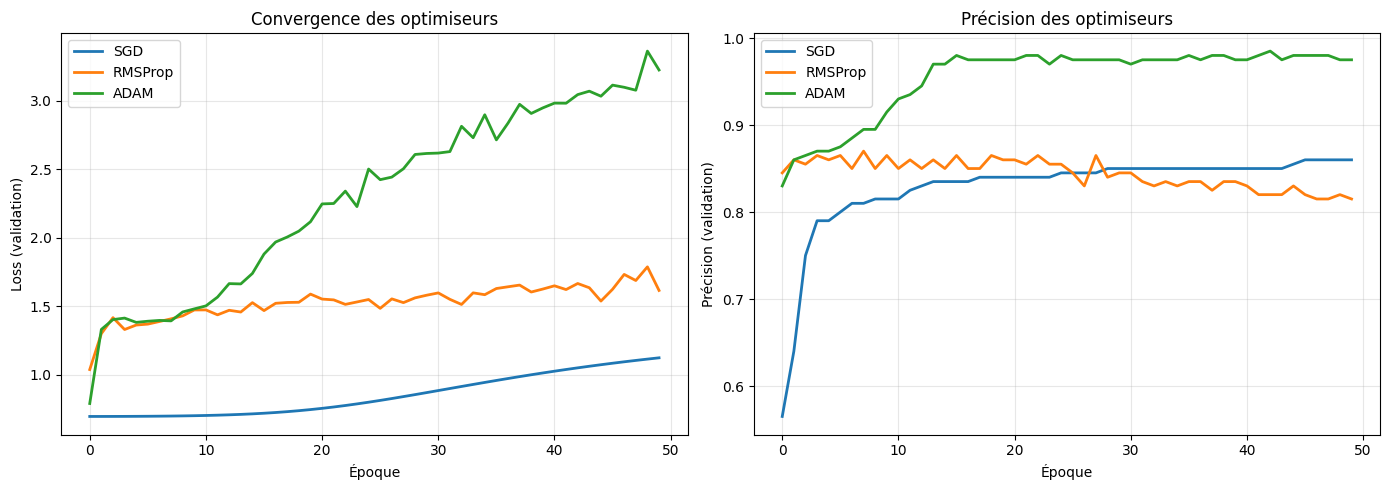

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(hist_sgd['val_loss'], label='SGD', linewidth=2)
axes[0].plot(hist_rmsprop['val_loss'], label='RMSProp', linewidth=2)
axes[0].plot(hist_adam['val_loss'], label='ADAM', linewidth=2)
axes[0].set_xlabel('Époque')
axes[0].set_ylabel('Loss (validation)')
axes[0].set_title('Convergence des optimiseurs')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Précision
axes[1].plot(hist_sgd['accuracy'], label='SGD', linewidth=2)
axes[1].plot(hist_rmsprop['accuracy'], label='RMSProp', linewidth=2)
axes[1].plot(hist_adam['accuracy'], label='ADAM', linewidth=2)
axes[1].set_xlabel('Époque')
axes[1].set_ylabel('Précision (validation)')
axes[1].set_title('Précision des optimiseurs')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('comparaison_optimiseurs.png', dpi=150, bbox_inches='tight')
plt.show()



# <center><b><u> 6. ÉTUDE DE L'IMPACT DE LA TAILLE DES BATCHS </u></b></center>

Test avec batch_size = 8...
Test avec batch_size = 32...
Test avec batch_size = 128...
Test avec batch_size = 256...


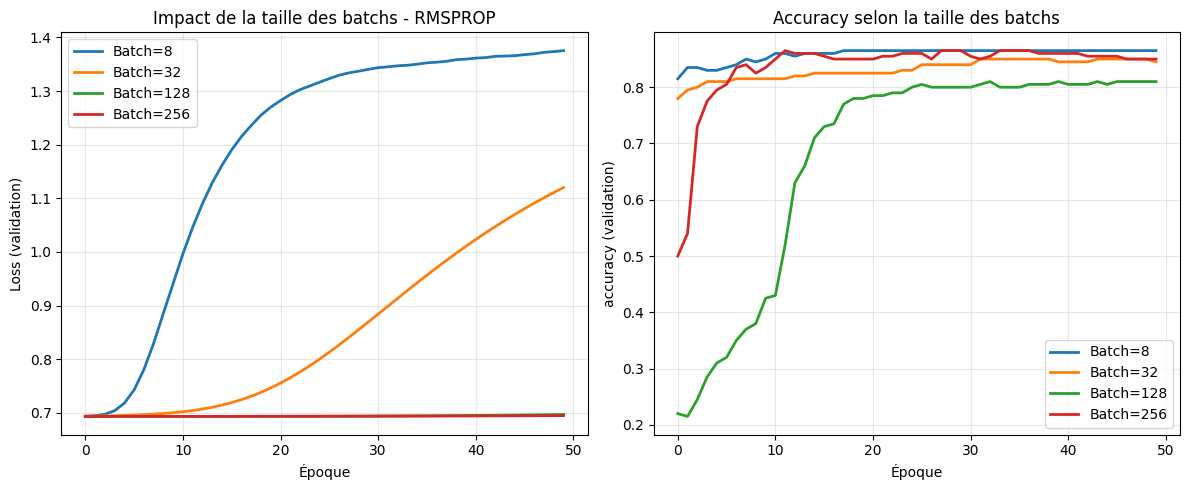


 Résumé des accuracies finaux par batch size ===
Batch size   8 : 86.50%
Batch size  32 : 84.50%
Batch size 128 : 81.00%
Batch size 256 : 85.00%

✓ Graphiques sauvegardés : comparaison_optimiseurs.png et impact_batch_size.png


In [24]:

batch_sizes = [8, 32, 128, 256]
resultats_batches = {bs: {} for bs in batch_sizes}

for bs in batch_sizes:
    print(f"Test avec batch_size = {bs}...")
    
    modele_test = ReseauNeurones()
    hist = sgd(modele_test, X_train, y_train, X_test, y_test, EPOCHS, bs, LEARNING_RATE)
    resultats_batches[bs] = hist

# Visualisation impact batch size
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for bs in batch_sizes:
    plt.plot(resultats_batches[bs]['val_loss'], label=f'Batch={bs}', linewidth=2)
plt.xlabel('Époque')
plt.ylabel('Loss (validation)')
plt.title('Impact de la taille des batchs - RMSPROP')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
for bs in batch_sizes:
    plt.plot(resultats_batches[bs]['accuracy'], label=f'Batch={bs}', linewidth=2)
plt.xlabel('Époque')
plt.ylabel('accuracy (validation)')
plt.title('Accuracy selon la taille des batchs')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('impact_batch_size.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n Résumé des accuracies finaux par batch size ===")
for bs in batch_sizes:
    print(f"Batch size {bs:3d} : {resultats_batches[bs]['accuracy'][-1]:.2%}")

print("\n✓ Graphiques sauvegardés : comparaison_optimiseurs.png et impact_batch_size.png")

Test avec batch_size = 8...
Test avec batch_size = 32...
Test avec batch_size = 128...
Test avec batch_size = 256...


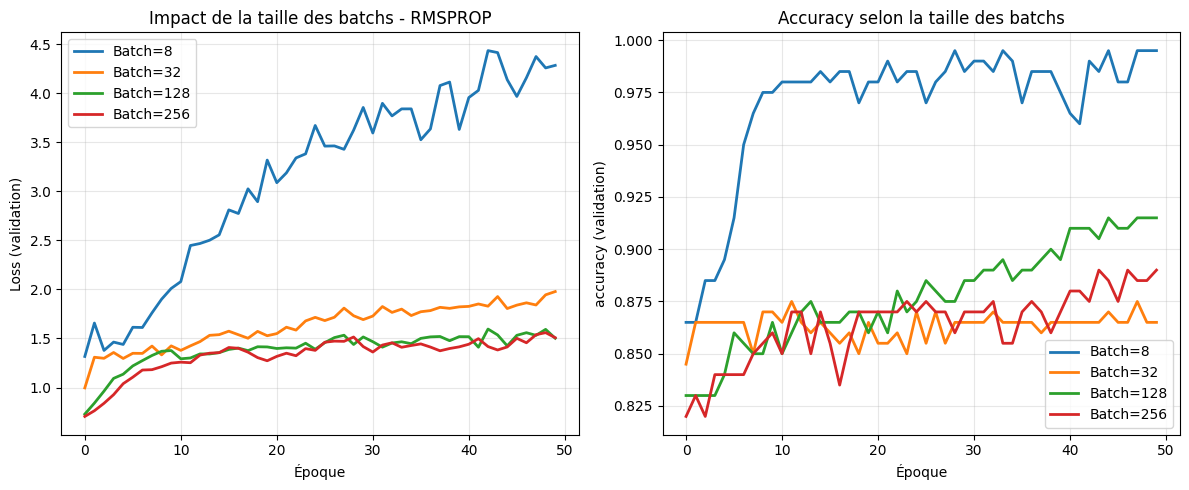


 Résumé des accuracies finaux par batch size ===
Batch size   8 : 99.50%
Batch size  32 : 86.50%
Batch size 128 : 91.50%
Batch size 256 : 89.00%

✓ Graphiques sauvegardés : comparaison_optimiseurs.png et impact_batch_size.png


In [25]:

batch_sizes = [8, 32, 128, 256]
resultats_batches = {bs: {} for bs in batch_sizes}

for bs in batch_sizes:
    print(f"Test avec batch_size = {bs}...")
    
    modele_test = ReseauNeurones()
    hist = rmsprop(modele_test, X_train, y_train, X_test, y_test, EPOCHS, bs, LEARNING_RATE)
    resultats_batches[bs] = hist

# Visualisation impact batch size
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for bs in batch_sizes:
    plt.plot(resultats_batches[bs]['val_loss'], label=f'Batch={bs}', linewidth=2)
plt.xlabel('Époque')
plt.ylabel('Loss (validation)')
plt.title('Impact de la taille des batchs - RMSPROP')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
for bs in batch_sizes:
    plt.plot(resultats_batches[bs]['accuracy'], label=f'Batch={bs}', linewidth=2)
plt.xlabel('Époque')
plt.ylabel('accuracy (validation)')
plt.title('Accuracy selon la taille des batchs')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('impact_batch_size.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n Résumé des accuracies finaux par batch size ===")
for bs in batch_sizes:
    print(f"Batch size {bs:3d} : {resultats_batches[bs]['accuracy'][-1]:.2%}")

print("\n✓ Graphiques sauvegardés : comparaison_optimiseurs.png et impact_batch_size.png")

Test avec batch_size = 8...
Test avec batch_size = 32...
Test avec batch_size = 128...
Test avec batch_size = 256...


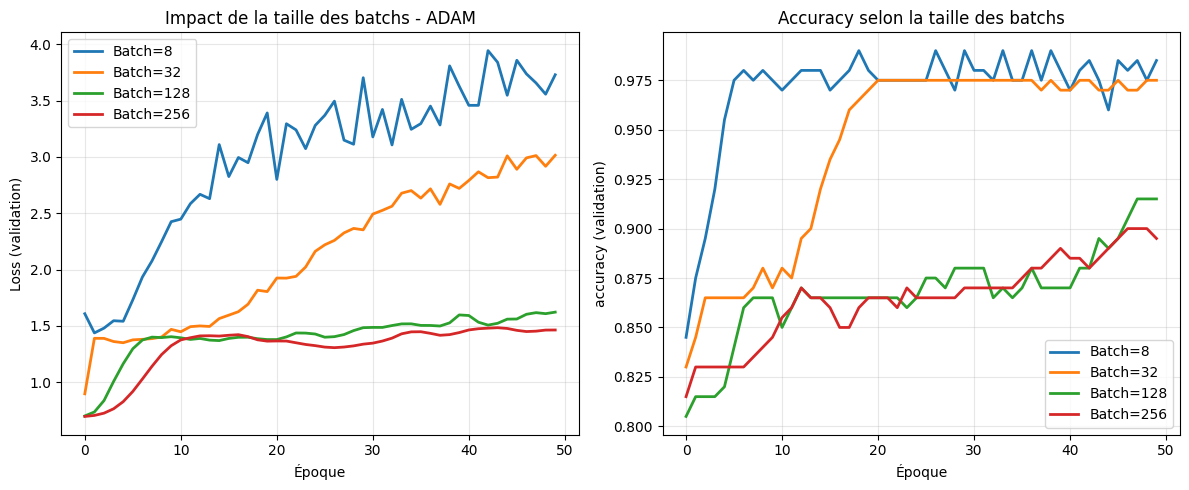


 Résumé des accuracies finaux par batch size ===
Batch size   8 : 98.50%
Batch size  32 : 97.50%
Batch size 128 : 91.50%
Batch size 256 : 89.50%

✓ Graphiques sauvegardés : comparaison_optimiseurs.png et impact_batch_size.png


In [23]:

batch_sizes = [8, 32, 128, 256]
resultats_batches = {bs: {} for bs in batch_sizes}

for bs in batch_sizes:
    print(f"Test avec batch_size = {bs}...")
    
    modele_test = ReseauNeurones()
    hist = adam(modele_test, X_train, y_train, X_test, y_test, EPOCHS, bs, LEARNING_RATE)
    resultats_batches[bs] = hist

# Visualisation impact batch size
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for bs in batch_sizes:
    plt.plot(resultats_batches[bs]['val_loss'], label=f'Batch={bs}', linewidth=2)
plt.xlabel('Époque')
plt.ylabel('Loss (validation)')
plt.title('Impact de la taille des batchs - ADAM')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
for bs in batch_sizes:
    plt.plot(resultats_batches[bs]['accuracy'], label=f'Batch={bs}', linewidth=2)
plt.xlabel('Époque')
plt.ylabel('accuracy (validation)')
plt.title('Accuracy selon la taille des batchs')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('impact_batch_size.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n Résumé des accuracies finaux par batch size ===")
for bs in batch_sizes:
    print(f"Batch size {bs:3d} : {resultats_batches[bs]['accuracy'][-1]:.2%}")

print("\n✓ Graphiques sauvegardés : comparaison_optimiseurs.png et impact_batch_size.png")

# <center><b><u> MERCI POUR VOTRE ATTENTION! </u></b></center>

<div style = "margin-left : 1100px; font-size : 25pt; color : gold;">
        <ul style = "list-style: none"> 
            <li><b> Hugo WALTER </b></li>
            <li><b> Keyssel FOKOU </b></li>
            <li><b> Théo GUERINEL </b></li>
        </ul>
</div>